In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Apr  3 12:48:56 2019

@author: vpfernandez
"""

import matplotlib.pyplot as plt
import numpy as np
import math
#import pandas as pd
import scipy.stats as si
from scipy.optimize import minimize
#from mibian import BS
import time
import copy
import psutil


# Functions

Functions that will be used for calculations, such as Geometric Brownian Motion, Payoffs for our options...


In [2]:
def progression(i,maxi,start_time):
    percent = i/maxi
    percent = int(percent / 0.01)
    
    percent_previt = (i-1)/maxi
    percent_previt = int(percent_previt / 0.01)
    
    if (percent % 10 == 0 and i != 0 and percent != percent_previt):

        tick = time.time() - start_time
        remaining = tick*(maxi/i - 1)
        if remaining > 60:
            print("{}% (remaining: {:.0f}m {:.2f}s)".format(int((i/maxi) *100), np.floor(tick*(maxi/i - 1) / 60), round(remaining - np.floor(tick*(maxi/i - 1) / 60)*60,2)))
        else:
            print("{}% (remaining: {:.2f}s)".format(int((i/maxi) *100),remaining))


def gbm(μ, σ, x0, t): 
    return math.exp(np.log(x0) + (μ - 1 / 2 * σ ** 2) * t + σ * np.random.normal(0,1,1))

def payoff_c(paths_t,K):
    array = paths_t[-1] - K
    zeros = (np.sign(array) + 1)/2
    array2 = array*zeros
    return array2.mean()

def payoff_p(paths_t,K):
    array = K - paths_t[-1]
    zeros = (np.sign(array) + 1)/2
    array2 = array*zeros
    return array2.mean()  

def payoff_lookback_c(paths_t):
    array = paths_t[-1]-np.amin(paths_t, axis=0)
    return array.mean()

def payoff_lookback_p(paths_t):
    array = np.amax(paths_t, axis=0)-paths_t[-1]
    return array.mean()

def BS_C(S, K, T, r, sigma):    
    d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S/K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return ((S*si.norm.cdf(d1,0,1)) - (K*np.exp(-r*T)*si.norm.cdf(d2,0,1)))

def BS_P(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S/K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return ((K*np.exp(-r*T) * si.norm.cdf(-d2,0,1)) - (S*si.norm.cdf(-d1,0,1)))

# VECTORIZE
BS_C_vect = np.vectorize(BS_C)
BS_P_vect = np.vectorize(BS_P)

def impliedcalc_c(val, S, K, T, r, initial_guess = 0.2):

    def wrapper_c(x):
        c = BS_C_vect(S, K, T, r, x)
        return abs(c-val)
    
    return float(minimize(wrapper_c,initial_guess).x)

    
def impliedcalc_p(val, S, K, T, r, initial_guess = 0.2):

    def wrapper_p(x):
        p = BS_P_vect(S, K, T, r, x)
        return abs(p-val)
    
    return float(minimize(wrapper_p,initial_guess).x)


# Main code: Variable setting

Naming all variables used, for generating random price paths with random jumps of -5%

In [3]:

if __name__ == '__main__':

    "##################################### Paths ##################################"
    
    S0 = 10
    sigma = 0.20
    K = 10
    r = 0/100
    t = 1/4
    
    n = 2_000_000
    steps = 199
    
    jump_size = 0.05 #
    jump_freq = 1 #per period
    jump_direc = -1
    
    memory_limit = 0.75
    
    "##############################################################################"
    
    vol_t = math.sqrt(t)*sigma
    r_t = ((1+r)**t)-1
    r_t = r * t
    
    dt = 1/steps
    wt = math.sqrt(dt)
    r_subt = ((1+r_t)**dt)-1
    r_subt = r_t*dt
    
    "##############################################################################"
    
    paths = np.zeros((1,1))
    jump = np.zeros((1,1))
    bytes_used = 8*((steps+8)*n)+2*99999
    availiable_memory = psutil.virtual_memory()[1]
    
    if bytes_used > availiable_memory*memory_limit:
        raise MemoryError("Insufficient Memory to complete the requested action: \nRequired: {} Go\nAvailiable: {} Go\nConsider reducing main matrices by a factor of {}".format(round(bytes_used/10**9,2),round((availiable_memory*memory_limit)/10**9,2),round(bytes_used/(availiable_memory*memory_limit),2)))
    else:
        paths = np.zeros((steps+1,n))
    


# Generating Paths

Using differential equation rather than the analytical solution, then transposing and showing the results for verification

10% (remaining: 46.22s)
20% (remaining: 43.93s)
30% (remaining: 39.73s)
40% (remaining: 33.97s)
50% (remaining: 28.24s)
60% (remaining: 22.57s)
70% (remaining: 16.83s)
80% (remaining: 11.16s)
90% (remaining: 5.57s)
Normalization
Done!

Transposition
Done!



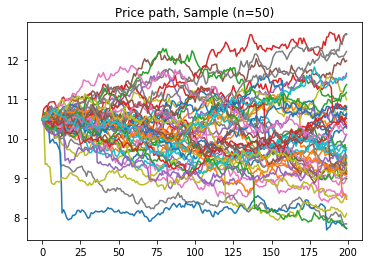

Done in 58.96 seconds


In [4]:
    "##############################################################################"
    
    start = time.time()
    paths[0] = S0
    
    for m in range(1,steps+1,1):
        
        progression(m,steps+1,start)
        
        jump = np.random.poisson(jump_freq/steps,n) * np.random.exponential(jump_size,n) * jump_direc        
        paths[m] = paths[m-1] * (1+(r_t*dt) + jump + (vol_t*np.random.normal(0,1,n)*wt))
    
    "##############################################################################"
    
    print("Normalization")
    for i in range(len(paths)):      
        paths[i] = paths[i] - r_t*i
    paths = paths - (paths[-1].mean()-S0)
    print("Done!\n")
    
    print("Transposition")
    paths_t = copy.deepcopy(np.transpose(paths))
    if paths_t.shape == paths.shape:
        raise Exception("Error in copy")
    else:
        print("Done!\n")
    
    sample = 50
    plt.figure()
    for rr in range(sample):
        plt.plot(paths_t[rr])
    plt.title("Price path, Sample (n={})".format(sample))
    plt.show()
    
    
    tick = time.time() - start
    print("Done in {} seconds".format(np.round(tick,2)))
    
    

# Volatitility Smile calculation

As we set random downward jumps on our stocks, we expect the smile to be higher for low strike prices and inversely for high strike prices

Strike = 9.0 
Val call = 1.1279 
Val put = 0.1279
BS call = 1.0712 
BS put = 0.0712
Implied: 24.69% / 24.69% 

Strike = 9.5 
Val call = 0.7547 
Val put = 0.2547
BS call = 0.6888 
BS put = 0.1888
Implied: 23.79% / 23.79% 

Strike = 10.0 
Val call = 0.4604 
Val put = 0.4604
BS call = 0.3988 
BS put = 0.3988
Implied: 23.10% / 23.10% 

Strike = 10.5 
Val call = 0.2535 
Val put = 0.7535
BS call = 0.2064 
BS put = 0.7064
Implied: 22.56% / 22.56% 

Strike = 11.0 
Val call = 0.1253 
Val put = 1.1253
BS call = 0.0954 
BS put = 1.0954
Implied: 22.16% / 22.16% 



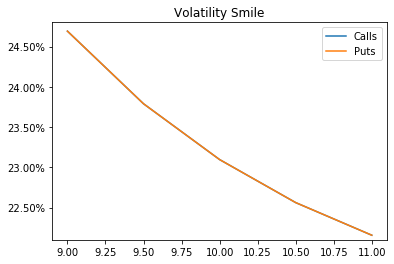

Payoff from Floating Lookback options (C): 0.5993 / Expected: 0.7732
Payoff from Floating Lookback options (P): 1.1421 / Expected: 0.8232
Done in 101.78 seconds


In [6]:
"#################################### SMILE ###################################"
    
mink = 10 - 1
maxk = 10 + 1
step_smile = 0.5
rangek = np.arange(mink,maxk+step_smile,step_smile)

implied_smile_c = np.zeros((len(rangek)))
implied_smile_p = np.zeros((len(rangek)))

for z, k in enumerate(rangek):

    val_c = payoff_c(paths,k)
    val_p = payoff_p(paths,k)    
    print("Strike = {} \nVal call = {} \nVal put = {}".format(k,np.round(val_c,4),np.round(val_p,4)))

    bsc_c = BS_C(S0, k, t, r, sigma)
    bsc_p = BS_P(S0, k, t, r, sigma)    
    print("BS call = {} \nBS put = {}".format(np.round(bsc_c,4),np.round(bsc_p,4)))

    impl_c = impliedcalc_c(val_c, S0, k, t, r, initial_guess=sigma)
    impl_p = impliedcalc_p(val_p, S0, k, t, r, initial_guess=sigma)    
    print("Implied: {:.2f}% / {:.2f}% \n".format(np.round(impl_c,4)*100,np.round(impl_p,4)*100))

    implied_smile_c[z] = impl_c
    implied_smile_p[z] = impl_p

plt.figure() 
plt.plot(rangek,implied_smile_c)
plt.plot(rangek,implied_smile_p)
axes = plt.gca()
axes.set_ylim([round(min(min(implied_smile_c),min(implied_smile_p)),3)-0.001,
               round(max(max(implied_smile_c),max(implied_smile_p)),3)+0.001])
axes.set_yticklabels(['{:,.2%}'.format(x) for x in axes.get_yticks()])
plt.legend(("Calls","Puts"))
plt.title("Volatility Smile")
#plt.title("Volatility Smile: Jump {}% / P(x) = {} per 3-month".format(int(jumps*100),int(times)))
plt.show()


payoff_lookback_c_val = payoff_lookback_c(paths)
payoff_lookback_p_val = payoff_lookback_p(paths)


print("Payoff from Floating Lookback options (C): {} / Expected: {}".format(round(payoff_lookback_c_val,4),round(0.773217,4)))
print("Payoff from Floating Lookback options (P): {} / Expected: {}".format(round(payoff_lookback_p_val,4),round(0.823217,4)))

tick = time.time() - start
print("Done in {} seconds".format(np.round(tick,2)))